In [1]:
import os
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import constants as con
from tqdm import tqdm

In [13]:
df_h=pd.read_csv('../data/rv/TOI1696_rv_h_new.dat', sep=',')[1:]
df_yj=pd.read_csv('../data/rv/TOI1696_rv_yj_new.dat', sep=',')[1:]
df_yj

,bjd,rv,rv_err
1,2.459488e+06,-0.029687,0.01424
2,2.459508e+06,0.068336,0.01874
3,2.459508e+06,0.061334,0.01405
4,2.459510e+06,0.105841,0.01895
5,2.459510e+06,0.045615,0.01487
6,2.459515e+06,-0.019704,0.01701
7,2.459515e+06,0.000000,0.01431
8,2.459531e+06,-0.046459,0.01720


In [14]:
np.std(df_h['rv'])*

0.04714023349565296

In [16]:
np.std(df_yj['rv'])

0.05105367114860615

In [3]:
df = df_yj

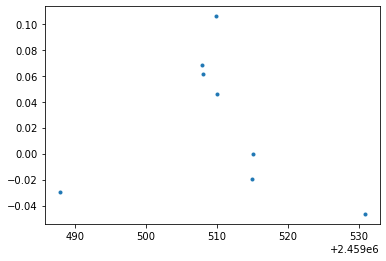

In [4]:
pl.plot(df['bjd'],df['rv'], '.')

In [5]:
T0 = 2458834.2011
P = 2.5003 #day
#Ms = 0.261#solar mass
#Mp = 68 #earth mass, tentative

#a_rs = (0.023 * con.au/ (0.268 * con.R_sun)).value

#b = 0.49
#inc = np.arccos(b / a_rs)#rad

In [6]:
def rv_model_K(K, t0, p, tm):  
    rv = -K* np.sin(2 * np.pi / p * (tm-t0))
    return rv
def rv_model_K_phase(K, ph):
    rv = -K*np.sin(ph*np.pi*2)
    return rv

In [7]:
# 横軸phaseでplotするために

def phase(OBS_JD, T0, P):
    n = np.floor((OBS_JD-T0)/P)
    tr_before = T0 + n * P             #the JD of the last transit (phase=0) before the observation
    ph = (OBS_JD - tr_before)/P
    return ph

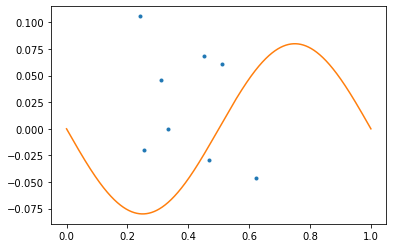

In [8]:
phase_obs = phase(df['bjd'], T0, P)
phase_pr = np.linspace(0,1,10000)

pl.plot(phase_obs, df['rv'], '.')
pl.plot(phase_pr, rv_model_K_phase(0.08, phase_pr), '-')

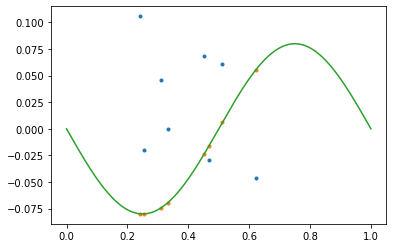

In [9]:
pl.plot(phase_obs, df['rv'], '.')
pl.plot(phase_obs, rv_model_K_phase(0.08, phase_obs), '.')
pl.plot(phase_pr, rv_model_K_phase(0.08, phase_pr), '-')

In [10]:
pd.DataFrame({'phase':phase_obs, 'rv_obs':df['rv'], 'rv_model':rv_model_K_phase(0.08, phase_obs)})

,phase,rv_obs,rv_model
1,0.468565,-0.029687,-0.015699
2,0.452044,0.068336,-0.023742
3,0.512003,0.061334,0.006027
4,0.241942,0.105841,-0.079897
5,0.310048,0.045615,-0.074373
6,0.253989,-0.019704,-0.079975
7,0.333323,0.000000,-0.069285
8,0.621247,-0.046459,0.055219


In [11]:
def logprob(K):
    rv_o = df['rv']
    rv_e = df['rv_err']
    rv_m = rv_model_K_phase(K, phase_obs)
    
    return -0.5 * np.sum(((rv_o - rv_m)/rv_e)**2)

In [12]:
import emcee

K=[0.05]

dim = 1
nwalkers = 100
nsteps=1000
pos0 = [K + 1e-4 * np.random.randn(dim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, dim, logprob)
sampler.run_mcmc(pos0, nsteps, progress=True)

100%|██████████| 1000/1000 [01:02<00:00, 16.40it/s]


State([[-0.02540408]
 [-0.02344816]
 [-0.03342809]
 [-0.03059407]
 [-0.03196959]
 [-0.01654594]
 [-0.03682775]
 [-0.02245153]
 [-0.04472589]
 [-0.03285478]
 [-0.0308526 ]
 [-0.03702332]
 [-0.04639085]
 [-0.0427667 ]
 [-0.04432539]
 [-0.03576773]
 [-0.02727201]
 [-0.03186029]
 [-0.02318532]
 [-0.0355552 ]
 [-0.02511179]
 [-0.03962838]
 [-0.03559028]
 [-0.03799476]
 [-0.0263018 ]
 [-0.03571851]
 [-0.03071607]
 [-0.03217671]
 [-0.0307531 ]
 [-0.02657644]
 [-0.03791211]
 [-0.02850859]
 [-0.03965809]
 [-0.02334534]
 [-0.03678752]
 [-0.02709058]
 [-0.03297558]
 [-0.03571958]
 [-0.03923064]
 [-0.03928866]
 [-0.03061084]
 [-0.03656458]
 [-0.03446604]
 [-0.03087806]
 [-0.02939547]
 [-0.03903686]
 [-0.03573312]
 [-0.02804024]
 [-0.04297807]
 [-0.03506277]
 [-0.0255284 ]
 [-0.0295641 ]
 [-0.01817554]
 [-0.02915174]
 [-0.03240401]
 [-0.03851304]
 [-0.03356188]
 [-0.0373157 ]
 [-0.02892989]
 [-0.02491647]
 [-0.03879171]
 [-0.03132058]
 [-0.03597251]
 [-0.01734755]
 [-0.03605916]
 [-0.0230325 ]
 [-0

how to add jitter term?

In [51]:
sampler.chain[:,:].shape

(100, 1000, 1)

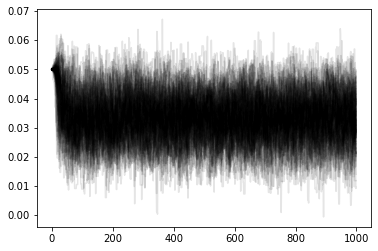

In [52]:
pl.plot(sampler.chain[:,:,0].T, color='k', alpha=0.1)

(array([2.000e+00, 4.000e+00, 2.000e+00, 6.000e+00, 7.000e+00, 1.200e+01,
        3.500e+01, 6.700e+01, 1.220e+02, 1.970e+02, 2.970e+02, 4.210e+02,
        6.040e+02, 8.140e+02, 1.158e+03, 1.590e+03, 1.900e+03, 2.495e+03,
        2.780e+03, 3.474e+03, 3.886e+03, 4.398e+03, 4.865e+03, 5.295e+03,
        5.593e+03, 5.386e+03, 5.233e+03, 4.907e+03, 4.657e+03, 4.034e+03,
        3.586e+03, 2.920e+03, 2.477e+03, 1.820e+03, 1.438e+03, 1.068e+03,
        8.470e+02, 5.910e+02, 4.020e+02, 2.570e+02, 1.380e+02, 9.100e+01,
        5.900e+01, 2.600e+01, 2.700e+01, 4.000e+00, 5.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([-0.00055539,  0.0007993 ,  0.00215398,  0.00350866,  0.00486334,
         0.00621802,  0.00757271,  0.00892739,  0.01028207,  0.01163675,
         0.01299143,  0.01434612,  0.0157008 ,  0.01705548,  0.01841016,
         0.01976485,  0.02111953,  0.02247421,  0.02382889,  0.02518357,
         0.02653826,  0.02789294,  0.02924762,  0.0306023 ,  0.03195698,
         0.

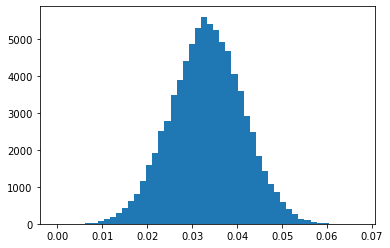

In [53]:
samples=sampler.chain[:,200:, :].reshape(-1)
df_chain= pd.DataFrame(samples)
pl.hist(samples, bins=50)

In [54]:
A,B,C,D,E=np.percentile(df_chain[0], [ 2.5, 16, 50, 84, 97.5], axis=0)
del1l =C-B   #1sigma
del1h=D-C
del2l=C-A   #2sigma
del2h=E-C 

best_K = C
best_K_err1=max(del1l,del1h)
best_K_err2=max(del2l,del2h)

print(best_K, best_K_err1, best_K_err2)

0.03330654255130501 0.008014834149377034 0.015808392810092418


収束判定まだしてないよ！

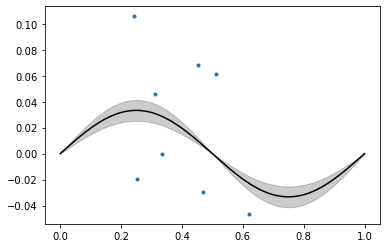

In [55]:
fig, ax = pl.subplots()

ax.plot(phase_obs, df['rv'], '.')

ax.plot(phase_pr, rv_model_K_phase(best_K, phase_pr), '-', color='k')

y1 = rv_model_K_phase(best_K+best_K_err1, phase_pr)
y2 = rv_model_K_phase(best_K-best_K_err1, phase_pr)

ax.fill_between(phase_pr, y1, y2, color='k', alpha=0.2)